### Autoencoders 

In [96]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [97]:
torch.manual_seed(0)

In [98]:
input_size = 784
h1 = 500
h2 = 300
bottleneck = 200
h3 = 300
h4 = 500
lr = 0.001
number_epouch = 5000
batch_size = 100

In [99]:
class Noisify:
    def __init__(self, Noise_level):
        self.Noise_level = Noise_level
    def __call__(self, sample):
        clean_image = sample[0] 
        noise = self.Noise_level * np.random.normal(0, 1, size=clean_image.shape)
        Noisy_image = clean_image + noise
        return (Noisy_image, clean_image), sample[1]

In [101]:
transformation = transforms.Compose([transforms.ToTensor(), Noisify(0.15)])
batch_size = 100

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transformation, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transformation, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 10.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 357kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.01MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.81MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
X_tr, y_tr = next(iter(train_loader))

In [6]:
Noise_level = 0.15
Noisy_X_tr = torch.Tensor.clone(X_tr)
for index in range(X_tr.shape[0]):
    noise = Noise_level * np.random.normal(0, 1, size=X_tr[index][0].shape)
    Noisy_X_tr[index][0] = X_tr[index][0] + noise

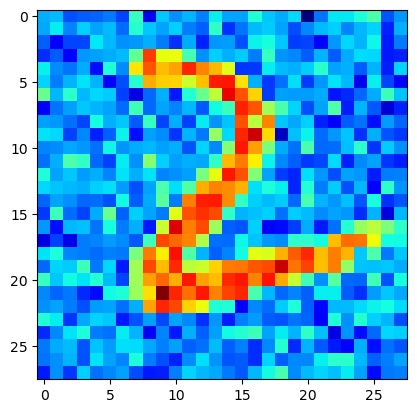

In [7]:
plt.imshow(Noisy_X_tr[160][0], cmap='jet')

In [8]:
train_loader

In [9]:
class Denoising_Autoencoder(nn.Module):
    def __init__(self, input_size, h1, h2, bottleneck, h3, h4):
        super(Denoising_Autoencoder, self).__init__()
        self.el1 = nn.Linear(input_size, h1)
        self.el2 = nn.Linear(h1, h2)
        self.el3 = nn.Linear(h2, bottleneck)

        self.Relu = nn.ReLU()

        self.d11 = nn.Linear(bottleneck, h3)
        self.dl2 = nn.Linear(h3, h4)
        self.dl3 = nn.Linear(h4, input_size)

    def encoder_forward(self, x):

        out = self.el1(x)
        out = self.Relu(out)
        out = self.el2(out)
        out = self.Relu(out)
        out = self.el3(out)
        
        return out
    
    def decoder_forward(self, x):

        out = self.d11(x)
        out = self.Relu(out)
        out = self.dl2(out)
        out = self.Relu(out)
        out = self.dl3(out)
        
        return out
    

In [10]:
#resize 
size = X_tr.shape[-1] * X_tr.shape[-2]
X_tr = X_tr.reshape(-1, size)
Noisy_X_tr = Noisy_X_tr.reshape(-1, size)

In [16]:
X_tr[0].shape

torch.Size([784])

In [ ]:
Model = Denoising_Autoencoder(input_size, h1, h2, bottleneck, h3, h4)
Cost = nn.MSELoss()
optimizer = optim.Adam(Model.parameters(), lr=lr)
number_epouch = 5

for epoch in range(number_epouch):
    for index in range(len(X_tr)):
        
        
        clean_image = X_tr[index]
        Noisy_image = Noisy_X_tr[index]
        
        #Forward pass

        encoder_forward = Model.encoder_forward(Noisy_image)
        output = Model.decoder_forward(encoder_forward)
        loss = Cost(output, clean_image)

        #backpro

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(loss)
        print(index)
    print(epoch)


In [57]:
def Denoise(Model, Noisy_image):
    encoder_forward = Model.encoder_forward(Noisy_image)
    output = Model.decoder_forward(encoder_forward)
    output = output.reshape(28, 28)
    return output 

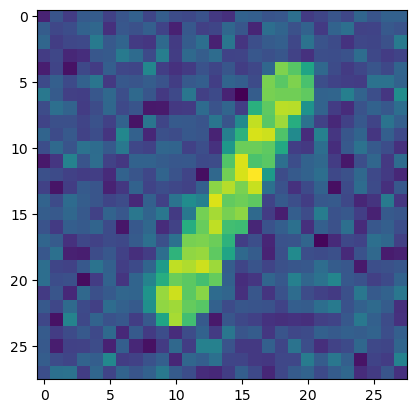

In [75]:
plt.imshow(Noisy_X_tr[100].reshape(28,28))

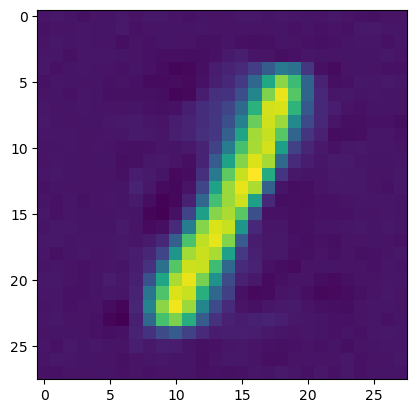

In [74]:
noisy_image1 = Noisy_X_tr[100]
cleaned_imaged = Denoise(Model,noisy_image1)
cleaned_imaged = cleaned_imaged.detach().numpy()

plt.imshow(cleaned_imaged)